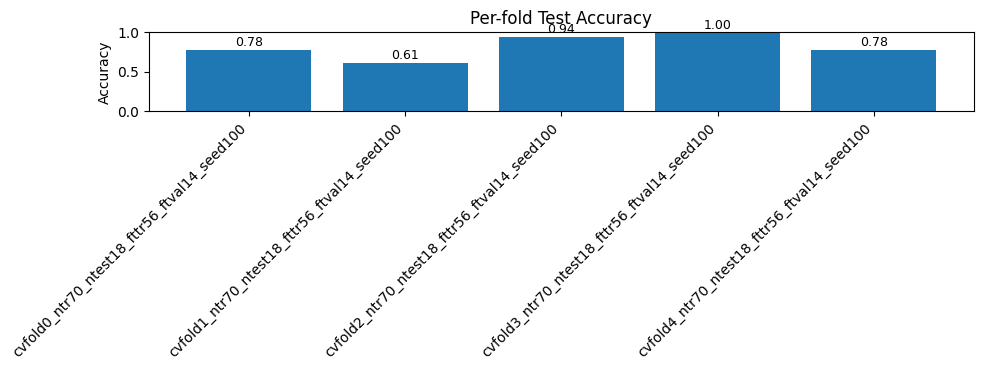

,tag,accuracy
0,cvfold0_ntr70_ntest18_fttr56_ftval14_seed100,0.777778
1,cvfold1_ntr70_ntest18_fttr56_ftval14_seed100,0.611111
2,cvfold2_ntr70_ntest18_fttr56_ftval14_seed100,0.944444
3,cvfold3_ntr70_ntest18_fttr56_ftval14_seed100,1.000000
4,cvfold4_ntr70_ntest18_fttr56_ftval14_seed100,0.777778


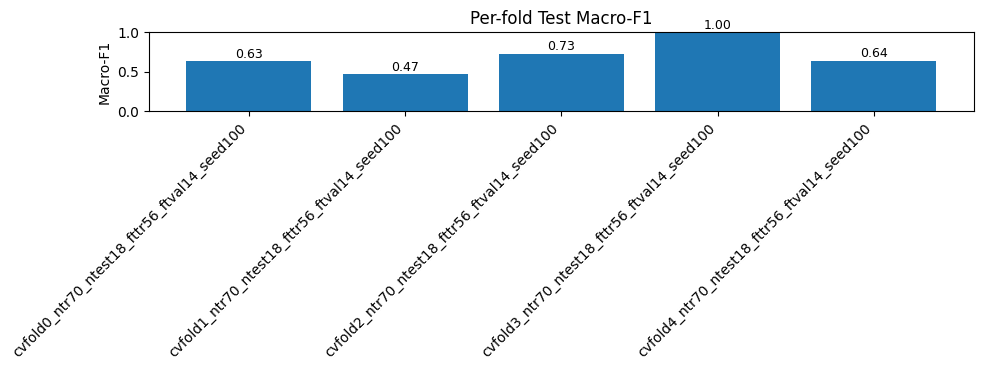

,tag,macro_f1
0,cvfold0_ntr70_ntest18_fttr56_ftval14_seed100,0.630952
1,cvfold1_ntr70_ntest18_fttr56_ftval14_seed100,0.466667
2,cvfold2_ntr70_ntest18_fttr56_ftval14_seed100,0.727273
3,cvfold3_ntr70_ntest18_fttr56_ftval14_seed100,1.000000
4,cvfold4_ntr70_ntest18_fttr56_ftval14_seed100,0.637080


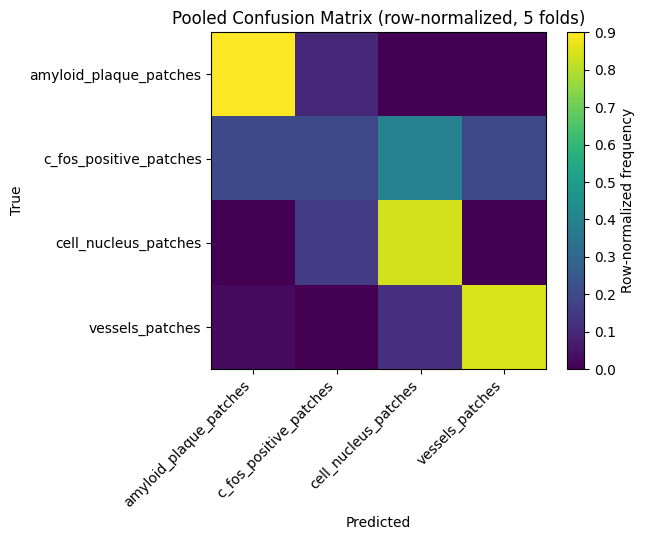

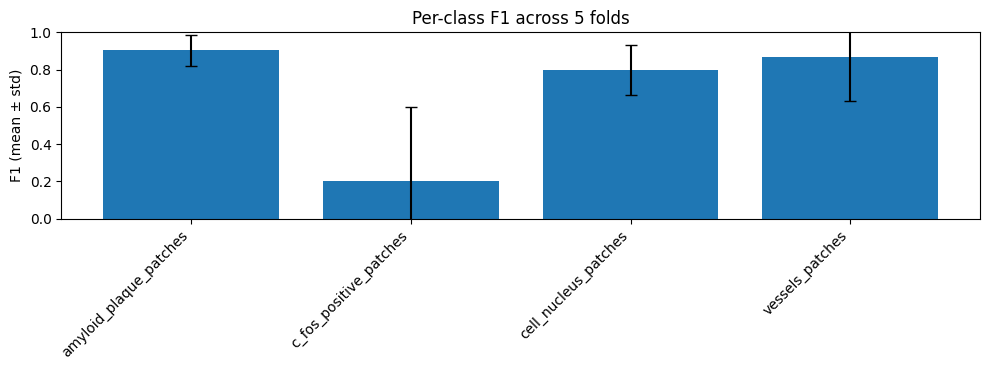

,class_name,f1_mean,f1_std
0,amyloid_plaque_patches,0.902857,0.082015
1,c_fos_positive_patches,0.200000,0.400000
2,cell_nucleus_patches,0.798485,0.134123
3,vessels_patches,0.868235,0.235223


[INFO] Folds aggregated: 5
[INFO] Accuracy mean±std: 0.8222 ± 0.1542
[INFO] Macro-F1 mean±std: 0.6924 ± 0.1960


In [1]:
# Inline visualization for 5-fold classification results
# Uses only matplotlib (no seaborn), one chart per figure, no custom colors.

import os, csv, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== YOUR PATHS ====
METRICS_ROOT = Path("/ministorage/adina/classification_eval/cls_metrics")
CLASSIFICATION_SUBDIR = "classification"
TAG_FILTER_REGEX = r"^cvfold[0-4]_ntr70_ntest18_fttr56_ftval14_seed100$"  # exact 5 folds

# ---------- Helpers ----------
def _find_tag_dirs(metrics_root: Path):
    base = metrics_root / CLASSIFICATION_SUBDIR
    if not base.exists():
        return []
    tags = []
    for tag_dir in sorted(base.iterdir()):
        if not tag_dir.is_dir():
            continue
        tag = tag_dir.name
        if TAG_FILTER_REGEX and not re.search(TAG_FILTER_REGEX, tag):
            continue
        pcm = tag_dir / f"per_class_metrics_{tag}.csv"
        cm  = tag_dir / f"confusion_matrix_{tag}.csv"
        preds = tag_dir / f"preds_{tag}.csv"  # optional
        if pcm.exists() and cm.exists():
            tags.append((tag, pcm, cm, preds if preds.exists() else None))
    return tags

def _load_overall_from_pcm(pcm_path: Path):
    rows = list(csv.reader(open(pcm_path)))
    if not rows:
        return None, None
    overall = rows[-1]
    # ["__OVERALL__", total, "ACC=0.xxxxxx", "MACRO_F1=0.xxxxxx", ""]
    try:
        acc = float(str(overall[2]).split("=")[-1])
        macro_f1 = float(str(overall[3]).split("=")[-1])
        return acc, macro_f1
    except Exception:
        return None, None

def _load_per_class_from_pcm(pcm_path: Path):
    df = pd.read_csv(pcm_path)
    return df[df["class_name"] != "__OVERALL__"][["class_name","support","precision","recall","f1_score"]].reset_index(drop=True)

def _load_cm(cm_path: Path):
    df = pd.read_csv(cm_path)
    classes = list(df.columns)[1:]
    mat = df.iloc[:, 1:].to_numpy(dtype=int)
    return classes, mat

def _row_normalize(cm: np.ndarray):
    denom = np.maximum(1, cm.sum(axis=1, keepdims=True))
    return cm.astype(float) / denom

# ---------- Load all folds ----------
tag_entries = _find_tag_dirs(METRICS_ROOT)
if not tag_entries:
    raise SystemExit(f"[ERR] No matching results under {METRICS_ROOT / CLASSIFICATION_SUBDIR}")

summary_rows = []
pooled_cm = None
classes_ref = None
per_class_f1 = {}  # class_name -> list of f1 across folds

for tag, pcm, cm, preds in tag_entries:
    acc, macro_f1 = _load_overall_from_pcm(pcm)
    if acc is None:
        continue
    summary_rows.append({"tag": tag, "accuracy": acc, "macro_f1": macro_f1})

    classes, mat = _load_cm(cm)
    if classes_ref is None:
        classes_ref = classes
        pooled_cm = mat.copy().astype(np.int64)
    else:
        assert classes == classes_ref, f"class mismatch in {cm}"
        pooled_cm += mat

    pc = _load_per_class_from_pcm(pcm)
    for _, row in pc.iterrows():
        cname = row["class_name"]
        f1 = float(row["f1_score"])
        per_class_f1.setdefault(cname, []).append(f1)

summary_df = pd.DataFrame(summary_rows).sort_values("tag").reset_index(drop=True)

# ---------- Plot: per-fold Accuracy ----------
plt.figure(figsize=(10, 3.8))
bars = plt.bar(summary_df["tag"], summary_df["accuracy"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Per-fold Test Accuracy")
plt.ylim(0, 1.0)
# annotate bars
for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 0.01, f"{h:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()
display(summary_df[["tag","accuracy"]])

# ---------- Plot: per-fold Macro-F1 ----------
plt.figure(figsize=(10, 3.8))
bars = plt.bar(summary_df["tag"], summary_df["macro_f1"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Macro-F1")
plt.title("Per-fold Test Macro-F1")
plt.ylim(0, 1.0)
for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 0.01, f"{h:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()
display(summary_df[["tag","macro_f1"]])

# ---------- Plot: pooled confusion matrix (row-normalized) ----------
cm_norm = _row_normalize(pooled_cm)
plt.figure(figsize=(6.5, 5.5))
plt.imshow(cm_norm, aspect="auto")
plt.colorbar(label="Row-normalized frequency")
plt.xticks(ticks=range(len(classes_ref)), labels=classes_ref, rotation=45, ha="right")
plt.yticks(ticks=range(len(classes_ref)), labels=classes_ref)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Pooled Confusion Matrix (row-normalized, 5 folds)")
plt.tight_layout()
plt.show()

# ---------- Plot: per-class F1 across folds (mean ± std) ----------
class_list = sorted(per_class_f1.keys())
means = [np.mean(per_class_f1[c]) if len(per_class_f1[c]) else 0.0 for c in class_list]
stds  = [np.std(per_class_f1[c])  if len(per_class_f1[c]) else 0.0 for c in class_list]

plt.figure(figsize=(10, 3.8))
x = np.arange(len(class_list))
plt.bar(x, means, yerr=stds, capsize=4)
plt.xticks(x, class_list, rotation=45, ha="right")
plt.ylabel("F1 (mean ± std)")
plt.title("Per-class F1 across 5 folds")
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

per_class_df = pd.DataFrame({"class_name": class_list, "f1_mean": means, "f1_std": stds})
display(per_class_df)

# ---------- Print quick aggregates ----------
print(f"[INFO] Folds aggregated: {len(summary_df)}")
if len(summary_df):
    print(f"[INFO] Accuracy mean±std: {summary_df['accuracy'].mean():.4f} ± {summary_df['accuracy'].std():.4f}")
    print(f"[INFO] Macro-F1 mean±std: {summary_df['macro_f1'].mean():.4f} ± {summary_df['macro_f1'].std():.4f}")


---

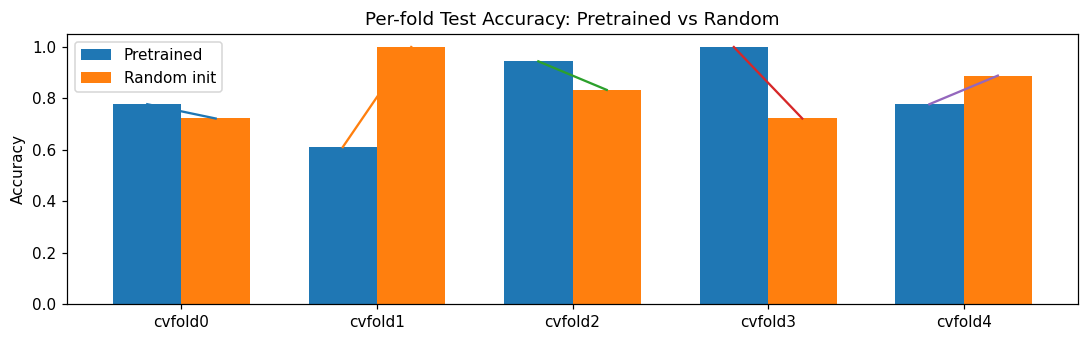

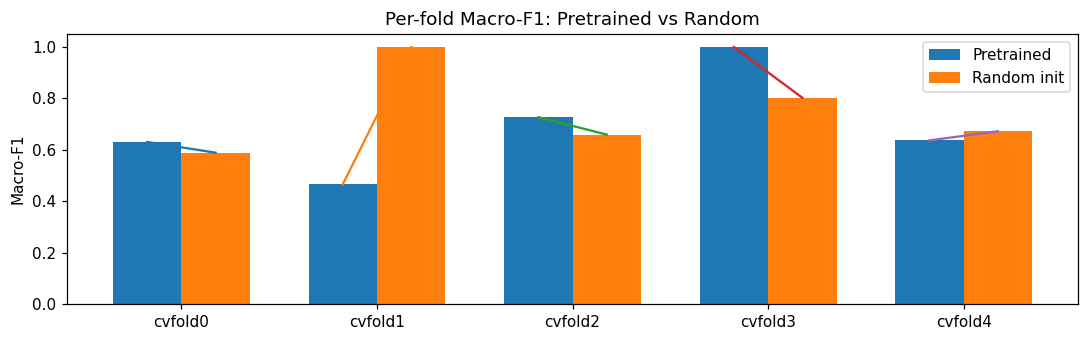

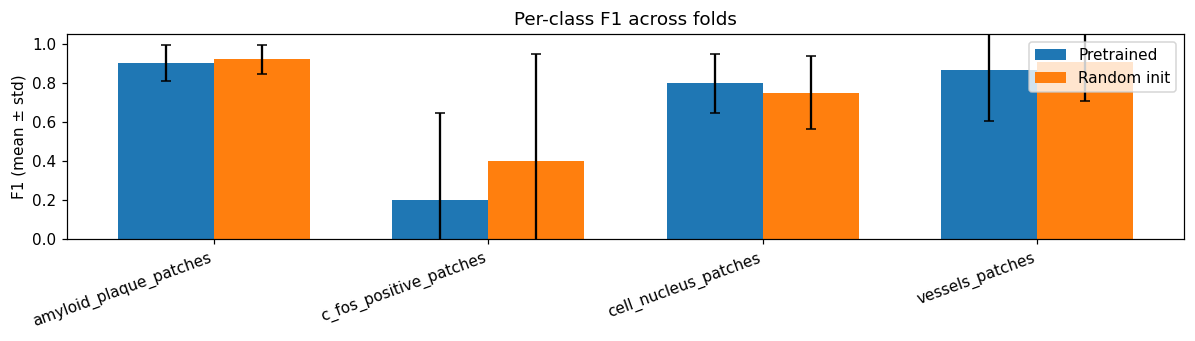

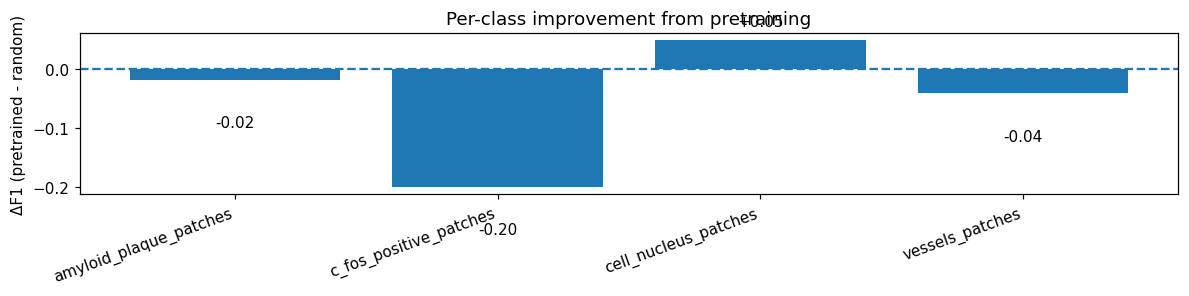

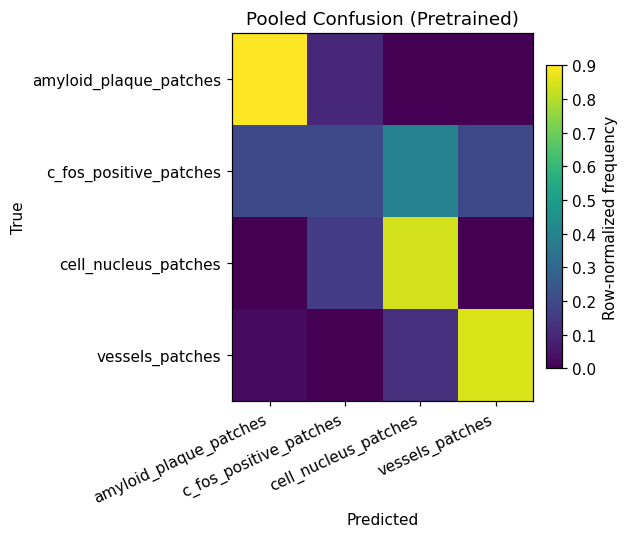

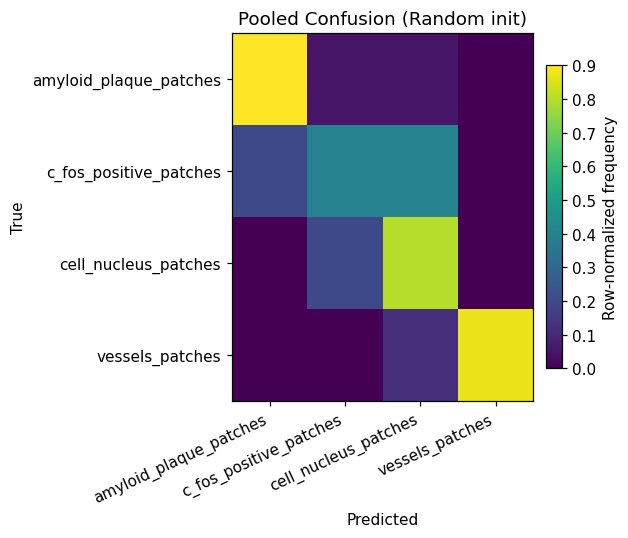


Accuracy summary:
  Pretrained: mean=0.822 ± 0.154
  Random   : mean=0.833 ± 0.118
  Δ (pre - rnd): mean=-0.011

Macro-F1 summary:
  Pretrained: mean=0.692 ± 0.196
  Random   : mean=0.745 ± 0.162
  Δ (pre - rnd): mean=-0.053


In [2]:
# === Compare pretrained vs random-init classification results across CV folds ===
# Edit these two directories to your actual outputs:
PRETRAIN_DIR = "/ministorage/adina/classification_eval/cls_metrics/classification"  # pretrained run
RANDINIT_DIR = "/ministorage/adina/classification_eval_rand/cls_metrics/classification"  # random-init run

# -------------------------------------------------------------------------------
# No seaborn; pure matplotlib as requested.
import os, re, glob, csv, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 110

def _find_fold_dirs(root):
    root = Path(root)
    if not root.exists():
        return []
    # match subdirs like "cvfold0_*", "cvfold1_*", ...
    return sorted([p for p in root.iterdir() if p.is_dir() and re.search(r"cvfold\d+_", p.name)])

def _load_per_class_metrics(csv_path):
    df = pd.read_csv(csv_path)
    # Separate per-class rows and the final OVERALL row (if present)
    cls_df = df[df["class_name"] != "__OVERALL__"].copy()
    overall = None
    tail = df[df["class_name"] == "__OVERALL__"]
    if len(tail):
        # tail row has columns: class_name, support, precision(ACC=...), recall(MACRO_F1=...), f1_score(blank)
        acc = None
        macro = None
        try:
            acc = float(str(tail.iloc[0,2]).split("ACC=")[-1])
        except Exception:
            pass
        try:
            macro = float(str(tail.iloc[0,3]).split("MACRO_F1=")[-1])
        except Exception:
            pass
        overall = dict(accuracy=acc, macro_f1=macro)
    # numeric casts
    for col in ("support","precision","recall","f1_score"):
        if col in cls_df.columns:
            cls_df[col] = pd.to_numeric(cls_df[col], errors="coerce")
    return cls_df, overall

def _load_confusion(csv_path):
    # first column is header "" then class names; first column of each row is class name
    with open(csv_path, "r", newline="") as f:
        reader = list(csv.reader(f))
    header = reader[0][1:]
    rows = [r[1:] for r in reader[1:]]
    mat = np.array(rows, dtype=int)
    return header, mat

def load_run(root_dir):
    """Return:
       folds: list of fold tags
       accs: dict tag->accuracy
       macros: dict tag->macroF1
       per_cls: dict tag->DataFrame(class_name, f1_score,...)
       pooled_cm: summed confusion matrix (numpy array), class_names
    """
    accs, macros, per_cls = {}, {}, {}
    pooled_cm = None
    cm_classes = None
    folds = []

    for fd in _find_fold_dirs(root_dir):
        tag = fd.name
        # locate files
        pcs = list(fd.glob("per_class_metrics_*.csv"))
        cms = list(fd.glob("confusion_matrix_*.csv"))
        if not pcs or not cms:
            continue

        # per-class metrics
        cdf, overall = _load_per_class_metrics(pcs[0])
        per_cls[tag] = cdf
        if overall is not None:
            accs[tag] = overall["accuracy"]
            macros[tag] = overall["macro_f1"]

        # confusion matrix
        cls_names, cm = _load_confusion(cms[0])
        if pooled_cm is None:
            pooled_cm = cm.astype(np.int64)
            cm_classes = cls_names
        else:
            # ensure same class order
            if cls_names != cm_classes:
                raise ValueError(f"Class order mismatch in {fd}: {cls_names} vs {cm_classes}")
            pooled_cm += cm.astype(np.int64)

        folds.append(tag)

    folds = sorted(folds, key=lambda s: int(re.search(r"cvfold(\d+)", s).group(1)) if re.search(r"cvfold(\d+)", s) else 9999)
    return folds, accs, macros, per_cls, (cm_classes, pooled_cm)

def row_normalize(cm):
    cm = cm.astype(float)
    with np.errstate(invalid="ignore", divide="ignore"):
        row_sums = cm.sum(axis=1, keepdims=True)
        norm = np.where(row_sums > 0, cm / row_sums, 0.0)
    return norm

def paired_tags(pre_folds, rand_folds):
    # match on "cvfoldX" prefix so we compare same fold id
    def fold_id(tag):
        m = re.search(r"cvfold(\d+)", tag)
        return int(m.group(1)) if m else None
    pf = {fold_id(t): t for t in pre_folds}
    rf = {fold_id(t): t for t in rand_folds}
    common = sorted(set(pf.keys()).intersection(rf.keys()))
    return [(pf[i], rf[i]) for i in common]

# ---- Load both runs
pre_folds, pre_acc, pre_mac, pre_cls, (pre_names, pre_cm) = load_run(PRETRAIN_DIR)
rnd_folds, rnd_acc, rnd_mac, rnd_cls, (rnd_names, rnd_cm) = load_run(RANDINIT_DIR)

if not pre_folds or not rnd_folds:
    print("[WARN] One of the result directories is empty. Check PRETRAIN_DIR / RANDINIT_DIR paths.")
else:
    if pre_names != rnd_names:
        print("[WARN] Class name order differs between runs. Plots may fail.")
    CLASS_NAMES = pre_names

    pairs = paired_tags(pre_folds, rnd_folds)
    # Build paired arrays for fold-wise comparison
    pair_labels = []
    acc_pre, acc_rnd, macro_pre, macro_rnd = [], [], [], []
    for ptag, rtag in pairs:
        pair_labels.append(re.search(r"(cvfold\d+)", ptag).group(1))
        acc_pre.append(pre_acc.get(ptag, np.nan))
        acc_rnd.append(rnd_acc.get(rtag, np.nan))
        macro_pre.append(pre_mac.get(ptag, np.nan))
        macro_rnd.append(rnd_mac.get(rtag, np.nan))

    # ---------- 1) Per-fold Accuracy (paired bars + connecting lines)
    x = np.arange(len(pair_labels))
    w = 0.35
    fig = plt.figure(figsize=(10,3.2))
    plt.bar(x - w/2, acc_pre, width=w, label="Pretrained")
    plt.bar(x + w/2, acc_rnd, width=w, label="Random init")
    for i in range(len(x)):
        if not (np.isnan(acc_pre[i]) or np.isnan(acc_rnd[i])):
            plt.plot([x[i]-w/2, x[i]+w/2], [acc_pre[i], acc_rnd[i]])
    plt.xticks(x, pair_labels, rotation=0)
    plt.ylim(0, 1.05)
    plt.ylabel("Accuracy")
    plt.title("Per-fold Test Accuracy: Pretrained vs Random")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- 2) Per-fold Macro-F1 (paired bars)
    fig = plt.figure(figsize=(10,3.2))
    plt.bar(x - w/2, macro_pre, width=w, label="Pretrained")
    plt.bar(x + w/2, macro_rnd, width=w, label="Random init")
    for i in range(len(x)):
        if not (np.isnan(macro_pre[i]) or np.isnan(macro_rnd[i])):
            plt.plot([x[i]-w/2, x[i]+w/2], [macro_pre[i], macro_rnd[i]])
    plt.xticks(x, pair_labels, rotation=0)
    plt.ylim(0, 1.05)
    plt.ylabel("Macro-F1")
    plt.title("Per-fold Macro-F1: Pretrained vs Random")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- 3) Per-class F1 (mean ± std across folds) for each run + difference
    def stack_class_f1(per_cls_dict, class_names):
        # returns dict class -> list of f1 over folds (matching only folds that contain the class row)
        out = {c: [] for c in class_names}
        for tag, df in per_cls_dict.items():
            by = df.set_index("class_name")
            for c in class_names:
                if c in by.index and not math.isnan(by.loc[c, "f1_score"]):
                    out[c].append(float(by.loc[c, "f1_score"]))
        return out

    pre_f1_by_class = stack_class_f1(pre_cls, CLASS_NAMES)
    rnd_f1_by_class = stack_class_f1(rnd_cls, CLASS_NAMES)

    def mean_std(d):
        mu = {k: (np.mean(v) if len(v) else np.nan) for k,v in d.items()}
        sd = {k: (np.std(v, ddof=1) if len(v)>1 else 0.0) for k,v in d.items()}
        return mu, sd

    pre_mu, pre_sd = mean_std(pre_f1_by_class)
    rnd_mu, rnd_sd = mean_std(rnd_f1_by_class)

    idx = np.arange(len(CLASS_NAMES))
    fig = plt.figure(figsize=(11,3.2))
    plt.bar(idx - w/2, [pre_mu[c] for c in CLASS_NAMES], yerr=[pre_sd[c] for c in CLASS_NAMES],
            width=w, label="Pretrained", capsize=3)
    plt.bar(idx + w/2, [rnd_mu[c] for c in CLASS_NAMES], yerr=[rnd_sd[c] for c in CLASS_NAMES],
            width=w, label="Random init", capsize=3)
    plt.xticks(idx, CLASS_NAMES, rotation=20, ha="right")
    plt.ylim(0, 1.05)
    plt.ylabel("F1 (mean ± std)")
    plt.title("Per-class F1 across folds")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Difference plot (Pretrained - Random) per class
    diffs = [ (pre_mu[c] - rnd_mu[c]) if not (np.isnan(pre_mu[c]) or np.isnan(rnd_mu[c])) else np.nan for c in CLASS_NAMES ]
    fig = plt.figure(figsize=(11,2.8))
    bars = plt.bar(idx, diffs)
    plt.axhline(0, linestyle="--")
    plt.xticks(idx, CLASS_NAMES, rotation=20, ha="right")
    plt.ylabel("ΔF1 (pretrained - random)")
    plt.title("Per-class improvement from pretraining")
    for i, d in enumerate(diffs):
        if not np.isnan(d):
            plt.text(i, d + (0.02 if d>=0 else -0.06), f"{d:+.2f}", ha="center", va="bottom" if d>=0 else "top")
    plt.tight_layout()
    plt.show()

    # ---------- 4) Pooled confusion matrices (row-normalized) for each run
    def plot_confusion(cm, class_names, title):
        cmn = row_normalize(cm)
        fig = plt.figure(figsize=(5.8,5))
        im = plt.imshow(cmn, aspect="auto")
        plt.colorbar(im, fraction=0.046, pad=0.04, label="Row-normalized frequency")
        plt.xticks(np.arange(len(class_names)), class_names, rotation=25, ha="right")
        plt.yticks(np.arange(len(class_names)), class_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(title)
        plt.tight_layout()
        plt.show()

    plot_confusion(pre_cm, CLASS_NAMES, "Pooled Confusion (Pretrained)")
    plot_confusion(rnd_cm, CLASS_NAMES, "Pooled Confusion (Random init)")

    # ---------- 5) Short table summary printed inline
    def _summary(arr_pre, arr_rnd, label):
        pre = np.array(arr_pre, dtype=float)
        rnd = np.array(arr_rnd, dtype=float)
        print(f"\n{label} summary:")
        print(f"  Pretrained: mean={np.nanmean(pre):.3f} ± {np.nanstd(pre, ddof=1):.3f}")
        print(f"  Random   : mean={np.nanmean(rnd):.3f} ± {np.nanstd(rnd, ddof=1):.3f}")
        print(f"  Δ (pre - rnd): mean={np.nanmean(pre - rnd):.3f}")

    _summary(acc_pre, acc_rnd, "Accuracy")
    _summary(macro_pre, macro_rnd, "Macro-F1")


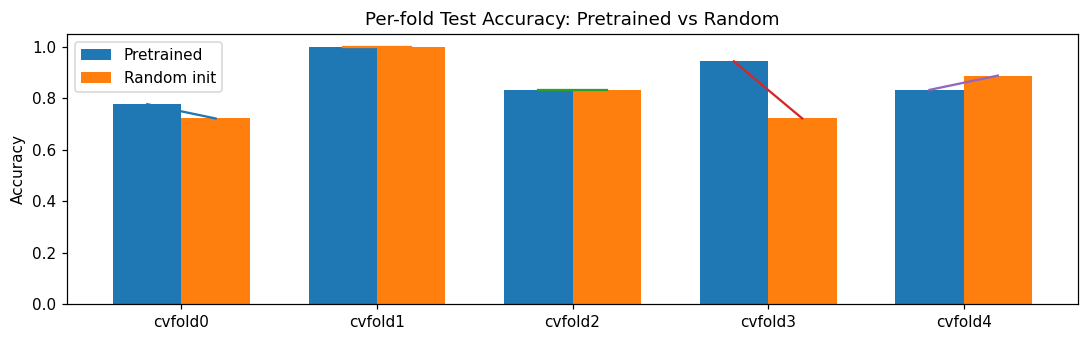

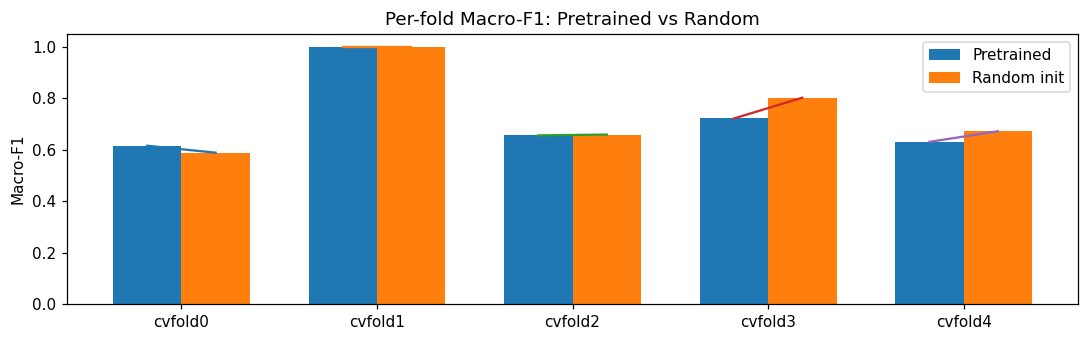

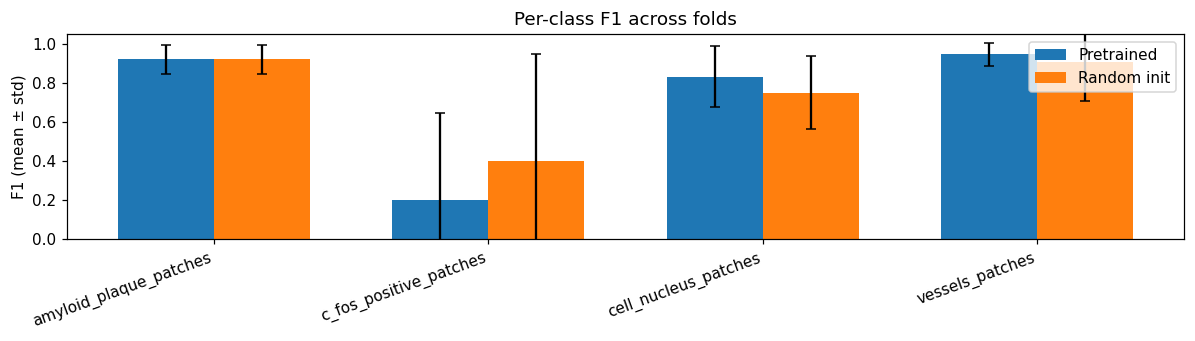

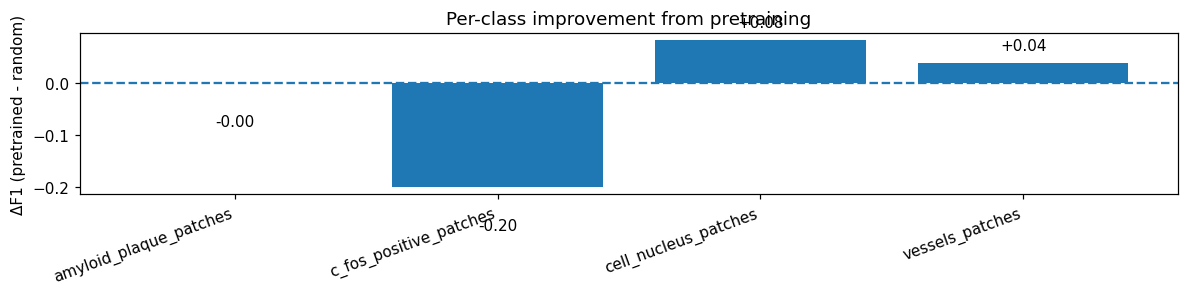

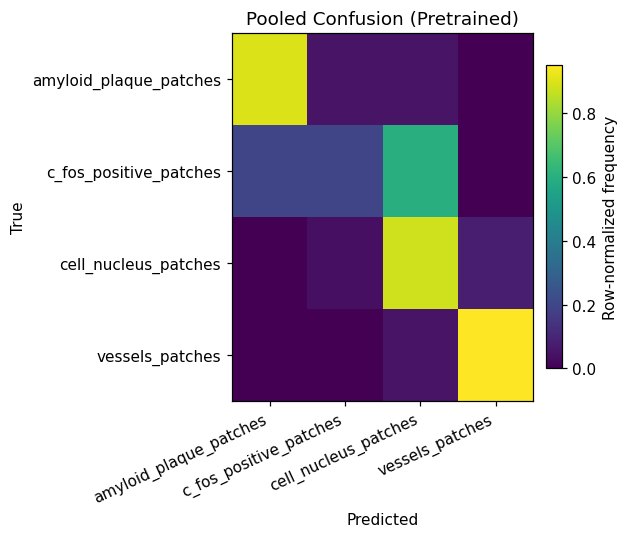

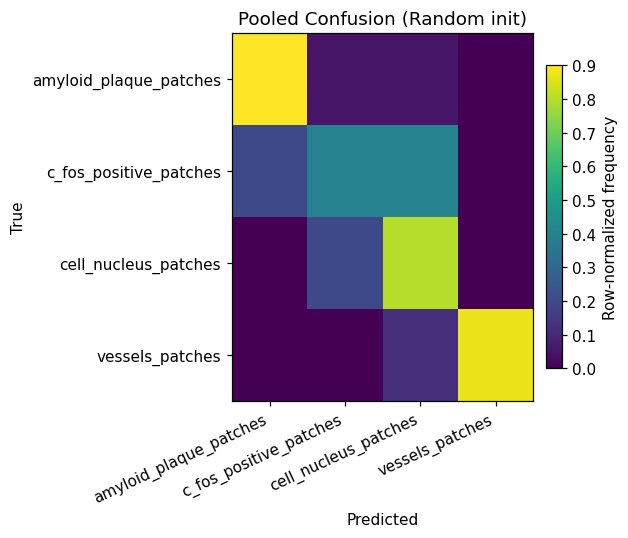


Accuracy summary:
  Pretrained: mean=0.878 ± 0.091
  Random   : mean=0.833 ± 0.118
  Δ (pre - rnd): mean=0.044

Macro-F1 summary:
  Pretrained: mean=0.725 ± 0.159
  Random   : mean=0.745 ± 0.162
  Δ (pre - rnd): mean=-0.020


In [4]:
# === Compare pretrained vs random-init classification results across CV folds ===
# Edit these two directories to your actual outputs:
PRETRAIN_DIR = "/ministorage/adina/classification_eval_image_only/cls_metrics/classification"  # pretrained run
RANDINIT_DIR = "/ministorage/adina/classification_eval_rand/cls_metrics/classification"  # random-init run

# -------------------------------------------------------------------------------
# No seaborn; pure matplotlib as requested.
import os, re, glob, csv, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 110

def _find_fold_dirs(root):
    root = Path(root)
    if not root.exists():
        return []
    # match subdirs like "cvfold0_*", "cvfold1_*", ...
    return sorted([p for p in root.iterdir() if p.is_dir() and re.search(r"cvfold\d+_", p.name)])

def _load_per_class_metrics(csv_path):
    df = pd.read_csv(csv_path)
    # Separate per-class rows and the final OVERALL row (if present)
    cls_df = df[df["class_name"] != "__OVERALL__"].copy()
    overall = None
    tail = df[df["class_name"] == "__OVERALL__"]
    if len(tail):
        # tail row has columns: class_name, support, precision(ACC=...), recall(MACRO_F1=...), f1_score(blank)
        acc = None
        macro = None
        try:
            acc = float(str(tail.iloc[0,2]).split("ACC=")[-1])
        except Exception:
            pass
        try:
            macro = float(str(tail.iloc[0,3]).split("MACRO_F1=")[-1])
        except Exception:
            pass
        overall = dict(accuracy=acc, macro_f1=macro)
    # numeric casts
    for col in ("support","precision","recall","f1_score"):
        if col in cls_df.columns:
            cls_df[col] = pd.to_numeric(cls_df[col], errors="coerce")
    return cls_df, overall

def _load_confusion(csv_path):
    # first column is header "" then class names; first column of each row is class name
    with open(csv_path, "r", newline="") as f:
        reader = list(csv.reader(f))
    header = reader[0][1:]
    rows = [r[1:] for r in reader[1:]]
    mat = np.array(rows, dtype=int)
    return header, mat

def load_run(root_dir):
    """Return:
       folds: list of fold tags
       accs: dict tag->accuracy
       macros: dict tag->macroF1
       per_cls: dict tag->DataFrame(class_name, f1_score,...)
       pooled_cm: summed confusion matrix (numpy array), class_names
    """
    accs, macros, per_cls = {}, {}, {}
    pooled_cm = None
    cm_classes = None
    folds = []

    for fd in _find_fold_dirs(root_dir):
        tag = fd.name
        # locate files
        pcs = list(fd.glob("per_class_metrics_*.csv"))
        cms = list(fd.glob("confusion_matrix_*.csv"))
        if not pcs or not cms:
            continue

        # per-class metrics
        cdf, overall = _load_per_class_metrics(pcs[0])
        per_cls[tag] = cdf
        if overall is not None:
            accs[tag] = overall["accuracy"]
            macros[tag] = overall["macro_f1"]

        # confusion matrix
        cls_names, cm = _load_confusion(cms[0])
        if pooled_cm is None:
            pooled_cm = cm.astype(np.int64)
            cm_classes = cls_names
        else:
            # ensure same class order
            if cls_names != cm_classes:
                raise ValueError(f"Class order mismatch in {fd}: {cls_names} vs {cm_classes}")
            pooled_cm += cm.astype(np.int64)

        folds.append(tag)

    folds = sorted(folds, key=lambda s: int(re.search(r"cvfold(\d+)", s).group(1)) if re.search(r"cvfold(\d+)", s) else 9999)
    return folds, accs, macros, per_cls, (cm_classes, pooled_cm)

def row_normalize(cm):
    cm = cm.astype(float)
    with np.errstate(invalid="ignore", divide="ignore"):
        row_sums = cm.sum(axis=1, keepdims=True)
        norm = np.where(row_sums > 0, cm / row_sums, 0.0)
    return norm

def paired_tags(pre_folds, rand_folds):
    # match on "cvfoldX" prefix so we compare same fold id
    def fold_id(tag):
        m = re.search(r"cvfold(\d+)", tag)
        return int(m.group(1)) if m else None
    pf = {fold_id(t): t for t in pre_folds}
    rf = {fold_id(t): t for t in rand_folds}
    common = sorted(set(pf.keys()).intersection(rf.keys()))
    return [(pf[i], rf[i]) for i in common]

# ---- Load both runs
pre_folds, pre_acc, pre_mac, pre_cls, (pre_names, pre_cm) = load_run(PRETRAIN_DIR)
rnd_folds, rnd_acc, rnd_mac, rnd_cls, (rnd_names, rnd_cm) = load_run(RANDINIT_DIR)

if not pre_folds or not rnd_folds:
    print("[WARN] One of the result directories is empty. Check PRETRAIN_DIR / RANDINIT_DIR paths.")
else:
    if pre_names != rnd_names:
        print("[WARN] Class name order differs between runs. Plots may fail.")
    CLASS_NAMES = pre_names

    pairs = paired_tags(pre_folds, rnd_folds)
    # Build paired arrays for fold-wise comparison
    pair_labels = []
    acc_pre, acc_rnd, macro_pre, macro_rnd = [], [], [], []
    for ptag, rtag in pairs:
        pair_labels.append(re.search(r"(cvfold\d+)", ptag).group(1))
        acc_pre.append(pre_acc.get(ptag, np.nan))
        acc_rnd.append(rnd_acc.get(rtag, np.nan))
        macro_pre.append(pre_mac.get(ptag, np.nan))
        macro_rnd.append(rnd_mac.get(rtag, np.nan))

    # ---------- 1) Per-fold Accuracy (paired bars + connecting lines)
    x = np.arange(len(pair_labels))
    w = 0.35
    fig = plt.figure(figsize=(10,3.2))
    plt.bar(x - w/2, acc_pre, width=w, label="Pretrained")
    plt.bar(x + w/2, acc_rnd, width=w, label="Random init")
    for i in range(len(x)):
        if not (np.isnan(acc_pre[i]) or np.isnan(acc_rnd[i])):
            plt.plot([x[i]-w/2, x[i]+w/2], [acc_pre[i], acc_rnd[i]])
    plt.xticks(x, pair_labels, rotation=0)
    plt.ylim(0, 1.05)
    plt.ylabel("Accuracy")
    plt.title("Per-fold Test Accuracy: Pretrained vs Random")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- 2) Per-fold Macro-F1 (paired bars)
    fig = plt.figure(figsize=(10,3.2))
    plt.bar(x - w/2, macro_pre, width=w, label="Pretrained")
    plt.bar(x + w/2, macro_rnd, width=w, label="Random init")
    for i in range(len(x)):
        if not (np.isnan(macro_pre[i]) or np.isnan(macro_rnd[i])):
            plt.plot([x[i]-w/2, x[i]+w/2], [macro_pre[i], macro_rnd[i]])
    plt.xticks(x, pair_labels, rotation=0)
    plt.ylim(0, 1.05)
    plt.ylabel("Macro-F1")
    plt.title("Per-fold Macro-F1: Pretrained vs Random")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- 3) Per-class F1 (mean ± std across folds) for each run + difference
    def stack_class_f1(per_cls_dict, class_names):
        # returns dict class -> list of f1 over folds (matching only folds that contain the class row)
        out = {c: [] for c in class_names}
        for tag, df in per_cls_dict.items():
            by = df.set_index("class_name")
            for c in class_names:
                if c in by.index and not math.isnan(by.loc[c, "f1_score"]):
                    out[c].append(float(by.loc[c, "f1_score"]))
        return out

    pre_f1_by_class = stack_class_f1(pre_cls, CLASS_NAMES)
    rnd_f1_by_class = stack_class_f1(rnd_cls, CLASS_NAMES)

    def mean_std(d):
        mu = {k: (np.mean(v) if len(v) else np.nan) for k,v in d.items()}
        sd = {k: (np.std(v, ddof=1) if len(v)>1 else 0.0) for k,v in d.items()}
        return mu, sd

    pre_mu, pre_sd = mean_std(pre_f1_by_class)
    rnd_mu, rnd_sd = mean_std(rnd_f1_by_class)

    idx = np.arange(len(CLASS_NAMES))
    fig = plt.figure(figsize=(11,3.2))
    plt.bar(idx - w/2, [pre_mu[c] for c in CLASS_NAMES], yerr=[pre_sd[c] for c in CLASS_NAMES],
            width=w, label="Pretrained", capsize=3)
    plt.bar(idx + w/2, [rnd_mu[c] for c in CLASS_NAMES], yerr=[rnd_sd[c] for c in CLASS_NAMES],
            width=w, label="Random init", capsize=3)
    plt.xticks(idx, CLASS_NAMES, rotation=20, ha="right")
    plt.ylim(0, 1.05)
    plt.ylabel("F1 (mean ± std)")
    plt.title("Per-class F1 across folds")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Difference plot (Pretrained - Random) per class
    diffs = [ (pre_mu[c] - rnd_mu[c]) if not (np.isnan(pre_mu[c]) or np.isnan(rnd_mu[c])) else np.nan for c in CLASS_NAMES ]
    fig = plt.figure(figsize=(11,2.8))
    bars = plt.bar(idx, diffs)
    plt.axhline(0, linestyle="--")
    plt.xticks(idx, CLASS_NAMES, rotation=20, ha="right")
    plt.ylabel("ΔF1 (pretrained - random)")
    plt.title("Per-class improvement from pretraining")
    for i, d in enumerate(diffs):
        if not np.isnan(d):
            plt.text(i, d + (0.02 if d>=0 else -0.06), f"{d:+.2f}", ha="center", va="bottom" if d>=0 else "top")
    plt.tight_layout()
    plt.show()

    # ---------- 4) Pooled confusion matrices (row-normalized) for each run
    def plot_confusion(cm, class_names, title):
        cmn = row_normalize(cm)
        fig = plt.figure(figsize=(5.8,5))
        im = plt.imshow(cmn, aspect="auto")
        plt.colorbar(im, fraction=0.046, pad=0.04, label="Row-normalized frequency")
        plt.xticks(np.arange(len(class_names)), class_names, rotation=25, ha="right")
        plt.yticks(np.arange(len(class_names)), class_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(title)
        plt.tight_layout()
        plt.show()

    plot_confusion(pre_cm, CLASS_NAMES, "Pooled Confusion (Pretrained)")
    plot_confusion(rnd_cm, CLASS_NAMES, "Pooled Confusion (Random init)")

    # ---------- 5) Short table summary printed inline
    def _summary(arr_pre, arr_rnd, label):
        pre = np.array(arr_pre, dtype=float)
        rnd = np.array(arr_rnd, dtype=float)
        print(f"\n{label} summary:")
        print(f"  Pretrained: mean={np.nanmean(pre):.3f} ± {np.nanstd(pre, ddof=1):.3f}")
        print(f"  Random   : mean={np.nanmean(rnd):.3f} ± {np.nanstd(rnd, ddof=1):.3f}")
        print(f"  Δ (pre - rnd): mean={np.nanmean(pre - rnd):.3f}")

    _summary(acc_pre, acc_rnd, "Accuracy")
    _summary(macro_pre, macro_rnd, "Macro-F1")


In [14]:
# --- Setup ---
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path("/ministorage/adina/classification_eval/folds3_test2/cls_metrics/classification")

# Regex to parse your tag strings:
# e.g. "pretrained_cvfold2_ntr40_ntest10_fttr32_ftval8_seed100"
TAG_RE = re.compile(
    r"^(?P<init_mode>pretrained|random)_"                # init mode
    r"(?P<split>cvfold\d+|percent_[^_]*)"               # split descriptor
    r"_ntr(?P<ntr>\d+)_ntest(?P<ntest>\d+)"             # pool sizes
    r"_fttr(?P<fttr>\d+)_ftval(?P<ftval>\d+)_seed(?P<seed>\d+)$"  # finetune split + seed
)

def parse_tag(tag: str):
    m = TAG_RE.match(tag)
    if not m:
        return None
    d = m.groupdict()
    # cast numeric fields
    for k in ["ntr", "ntest", "fttr", "ftval", "seed"]:
        d[k] = int(d[k])
    return d

def read_overall_from_per_class_metrics(csv_path: Path):
    """
    Your per_class_metrics has an '__OVERALL__' row with 'ACC=...' and 'MACRO_F1=...'.
    We'll parse those two values cleanly.
    """
    df = pd.read_csv(csv_path)
    # last row should be __OVERALL__
    last = df.iloc[-1]
    # columns: class_name, support, precision, recall, f1_score
    # last row has strings like 'ACC=0.812500' and 'MACRO_F1=0.755000'
    acc_str = str(last["precision"])
    mf1_str = str(last["recall"])
    def _parse_metric(s, key):
        # expects e.g. "ACC=0.812500"
        if isinstance(s, str) and s.startswith(key + "="):
            try:
                return float(s.split("=", 1)[1])
            except Exception:
                return np.nan
        return np.nan
    acc = _parse_metric(acc_str, "ACC")
    macro_f1 = _parse_metric(mf1_str, "MACRO_F1")
    support = int(last["support"])
    return acc, macro_f1, support

def collect_runs(root: Path):
    rows = []
    for sub in sorted(root.iterdir()):
        if not sub.is_dir():
            continue
        tag = sub.name
        meta = parse_tag(tag)
        if not meta:
            # skip anything that doesn't follow the tag convention
            continue

        # find the per_class_metrics CSV (be tolerant to exact filename)
        pcs = list(sub.glob(f"per_class_metrics_{tag}.csv"))
        if not pcs:
            # fallback: any per_class_metrics*.csv in the folder
            pcs = list(sub.glob("per_class_metrics*.csv"))
        if not pcs:
            continue
        per_class_csv = pcs[0]

        acc, macro_f1, support = read_overall_from_per_class_metrics(per_class_csv)
        rows.append({
            "tag": tag,
            "path": str(sub),
            **meta,                      # init_mode, split, ntr, ntest, fttr, ftval, seed
            "acc": acc,
            "macro_f1": macro_f1,
            "support_total": support,
        })
    return pd.DataFrame(rows)

df = collect_runs(ROOT)
df.sort_values(["init_mode", "fttr", "tag"], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()


,tag,path,init_mode,split,ntr,ntest,fttr,ftval,seed,acc,macro_f1,support_total
0,pretrained_cvfold0_ntr8_ntest8_fttr6_ftval2_se...,/ministorage/adina/classification_eval/folds3_...,pretrained,cvfold0,8,8,6,2,100,0.375,0.350000,8
1,pretrained_cvfold1_ntr8_ntest8_fttr6_ftval2_se...,/ministorage/adina/classification_eval/folds3_...,pretrained,cvfold1,8,8,6,2,100,0.250,0.111111,8
2,pretrained_cvfold2_ntr8_ntest8_fttr6_ftval2_se...,/ministorage/adina/classification_eval/folds3_...,pretrained,cvfold2,8,8,6,2,100,0.500,0.541667,8
3,pretrained_cvfold0_ntr11_ntest8_fttr9_ftval2_s...,/ministorage/adina/classification_eval/folds3_...,pretrained,cvfold0,11,8,9,2,100,0.625,0.566667,8
4,pretrained_cvfold1_ntr11_ntest8_fttr9_ftval2_s...,/ministorage/adina/classification_eval/folds3_...,pretrained,cvfold1,11,8,9,2,100,0.500,0.500000,8


In [15]:
# Optional: quick sanity check
print("Found runs:", len(df))
print(df.groupby(["init_mode"])["tag"].count())
print(df.groupby(["init_mode", "fttr"])["acc"].agg(["count","mean","std"]).head(12))


Found runs: 108
init_mode
pretrained    54
random        54
Name: tag, dtype: int64
                 count      mean       std
init_mode  fttr                           
pretrained 6         3  0.375000  0.125000
           9         3  0.583333  0.072169
           11        3  0.625000  0.216506
           14        3  0.625000  0.216506
           16        3  0.791667  0.072169
           21        3  0.708333  0.072169
           23        3  0.666667  0.072169
           26        3  0.625000  0.125000
           28        3  0.708333  0.072169
           30        3  0.708333  0.072169
           33        3  0.666667  0.072169
           35        3  0.708333  0.144338


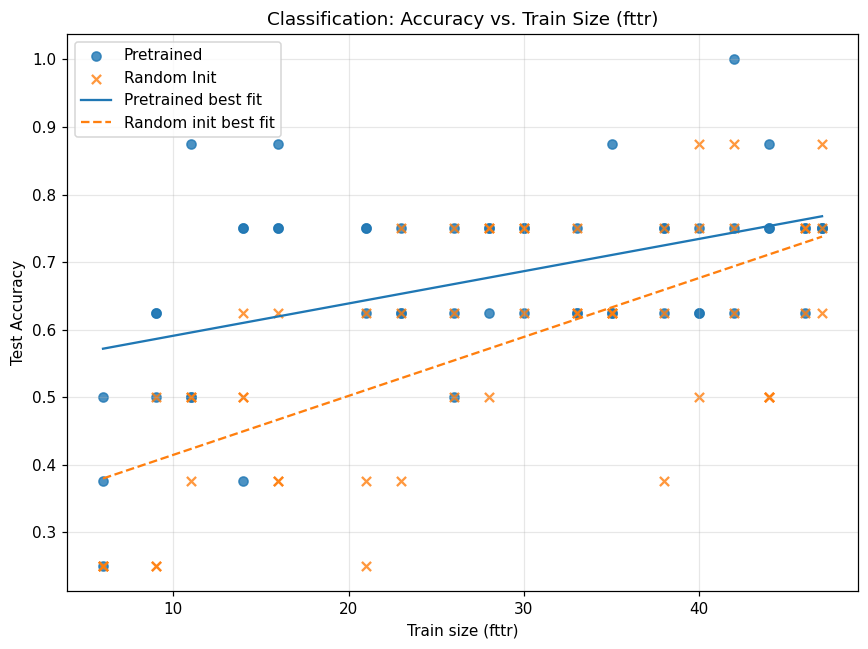

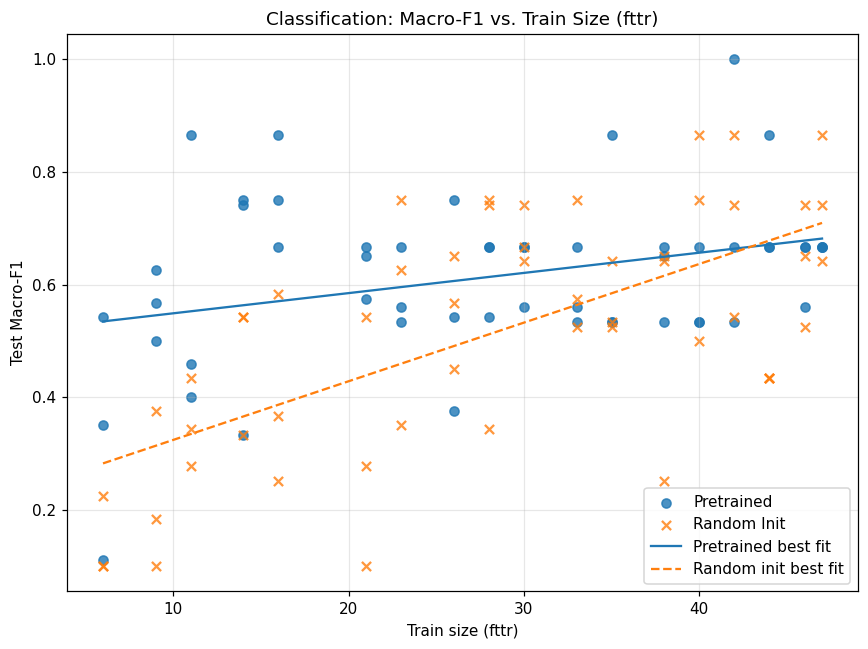

In [16]:
# --- Plot helper: scatter + simple linear fit line ---
def plot_metric_vs_train(metric="acc", title=None, y_label=None):
    assert metric in ("acc", "macro_f1")
    ylab = y_label or (metric.upper())
    ttl = title or f"Classification: {ylab} vs. train_size (fttr)"

    # two groups: pretrained / random
    g_pre = df[df["init_mode"] == "pretrained"]
    g_rand = df[df["init_mode"] == "random"]

    plt.figure(figsize=(8,6))

    # scatter points (do not set explicit colors as requested)
    plt.scatter(g_pre["fttr"], g_pre[metric], label="Pretrained", alpha=0.8, marker="o")
    plt.scatter(g_rand["fttr"], g_rand[metric], label="Random Init", alpha=0.8, marker="x")

    # best-fit lines (1st-degree poly) if we have enough points
    def add_fit_line(g, label, linestyle="-"):
        if len(g) >= 2 and g["fttr"].nunique() >= 2:
            xs = g["fttr"].values.astype(float)
            ys = g[metric].values.astype(float)
            # Fit y = a*x + b
            a, b = np.polyfit(xs, ys, 1)
            x_line = np.linspace(xs.min(), xs.max(), 100)
            y_line = a*x_line + b
            plt.plot(x_line, y_line, linestyle=linestyle, label=f"{label} best fit")

    add_fit_line(g_pre, "Pretrained", linestyle="-")
    add_fit_line(g_rand, "Random init", linestyle="--")

    plt.title(ttl)
    plt.xlabel("Train size (fttr)")
    plt.ylabel(ylab)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot accuracy
plot_metric_vs_train(metric="acc", title="Classification: Accuracy vs. Train Size (fttr)", y_label="Test Accuracy")

# Plot macro-F1 (optional)
plot_metric_vs_train(metric="macro_f1", title="Classification: Macro-F1 vs. Train Size (fttr)", y_label="Test Macro-F1")


Found runs:


,mode,train_size,fold_id,acc,file
0,pretrained,6,0,0.375,/ministorage/adina/classification_eval/folds3_...
1,pretrained,6,1,0.250,/ministorage/adina/classification_eval/folds3_...
2,pretrained,6,2,0.500,/ministorage/adina/classification_eval/folds3_...
3,pretrained,9,0,0.625,/ministorage/adina/classification_eval/folds3_...
4,pretrained,9,1,0.500,/ministorage/adina/classification_eval/folds3_...
...,...,...,...,...,...
103,random,46,1,0.750,/ministorage/adina/classification_eval/folds3_...
104,random,46,2,0.625,/ministorage/adina/classification_eval/folds3_...
105,random,47,0,0.750,/ministorage/adina/classification_eval/folds3_...
106,random,47,1,0.625,/ministorage/adina/classification_eval/folds3_...


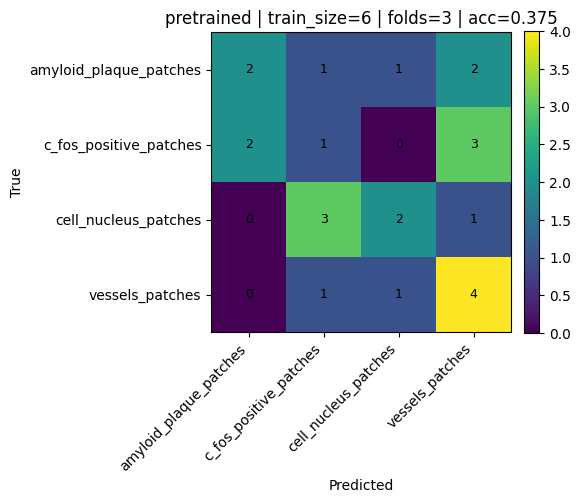

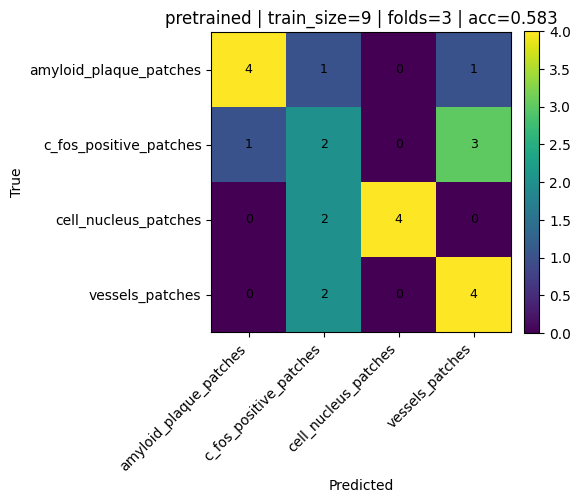

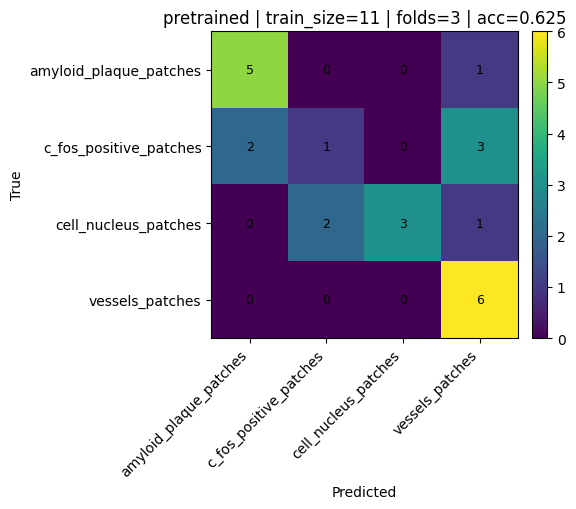

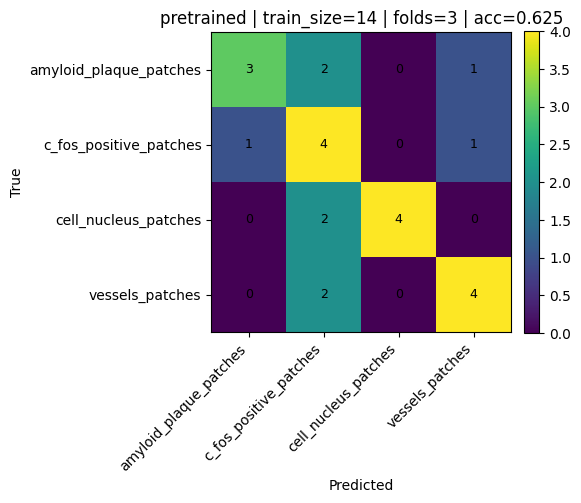

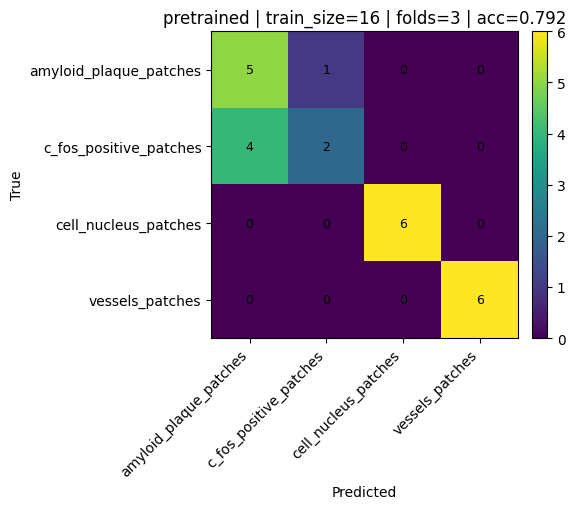

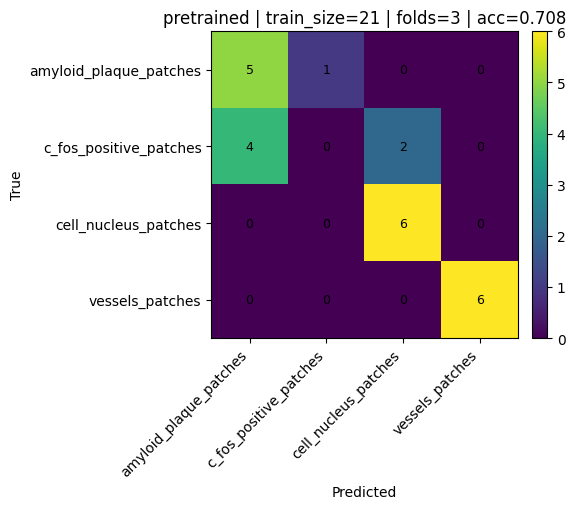

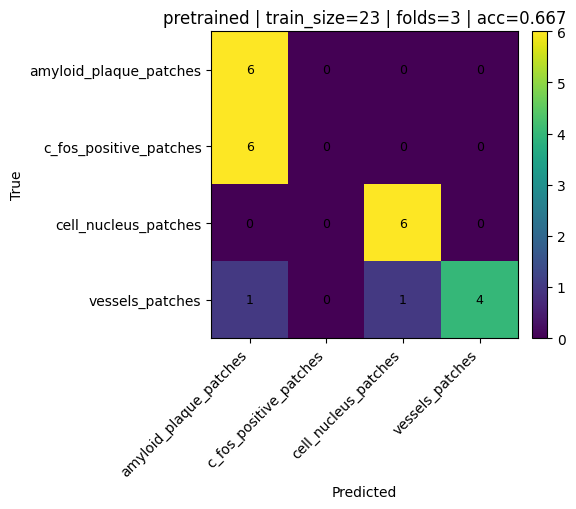

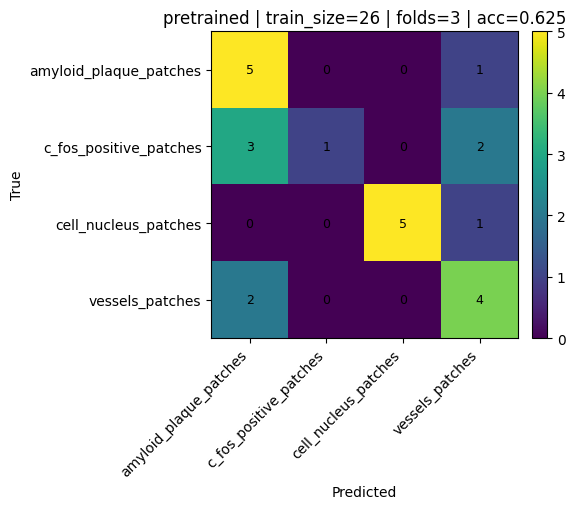

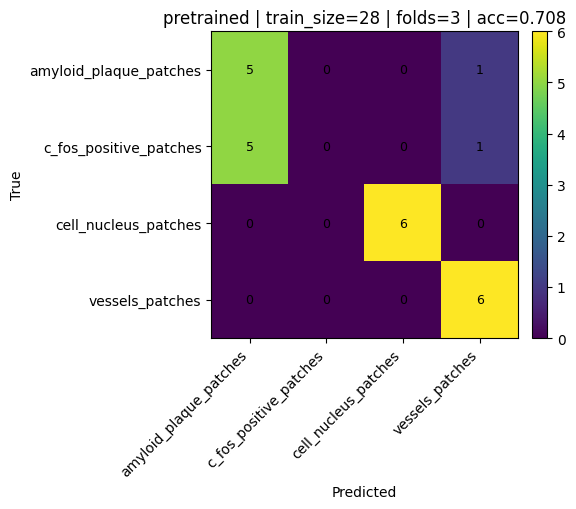

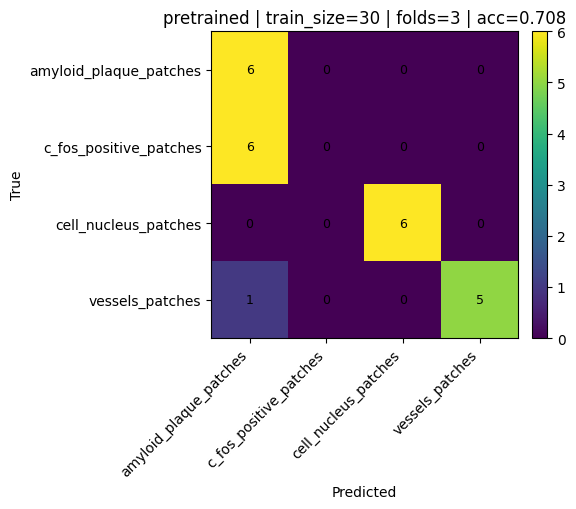

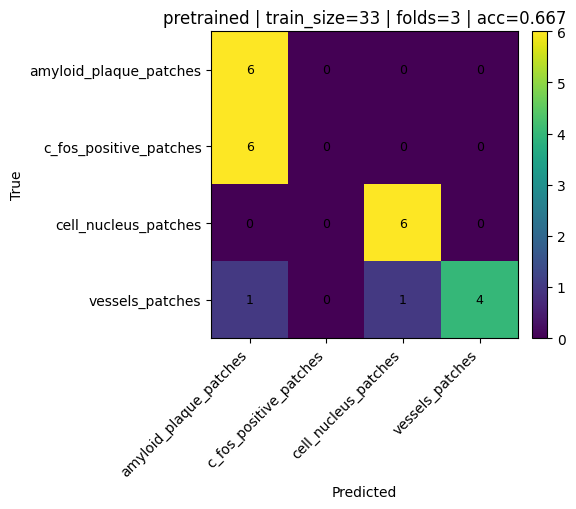

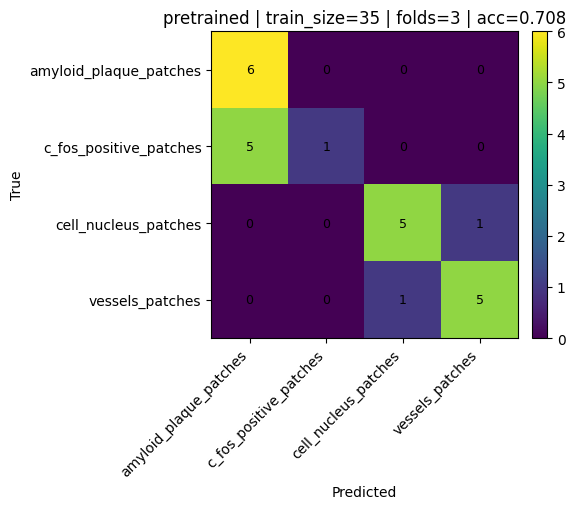

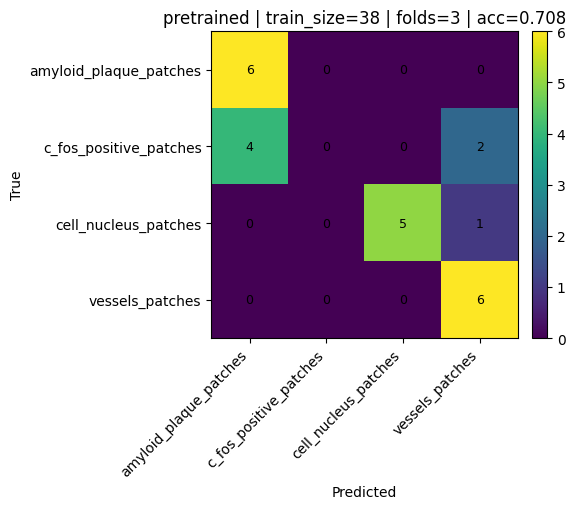

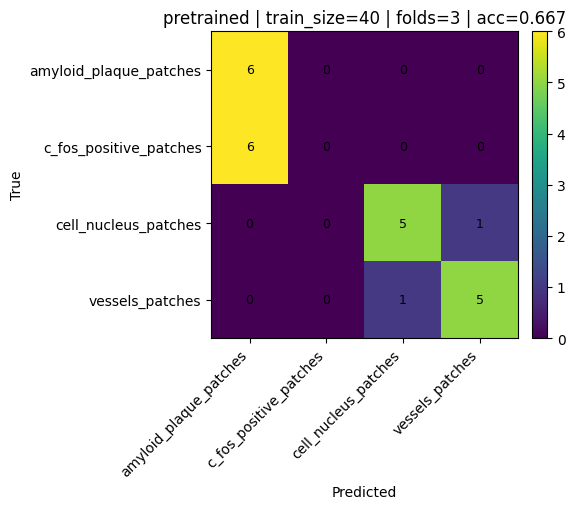

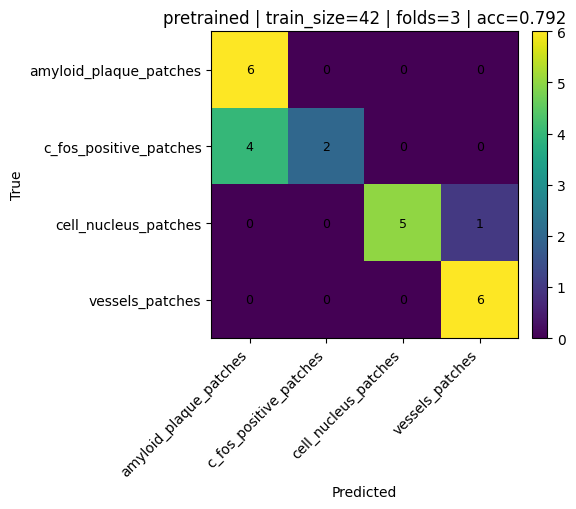

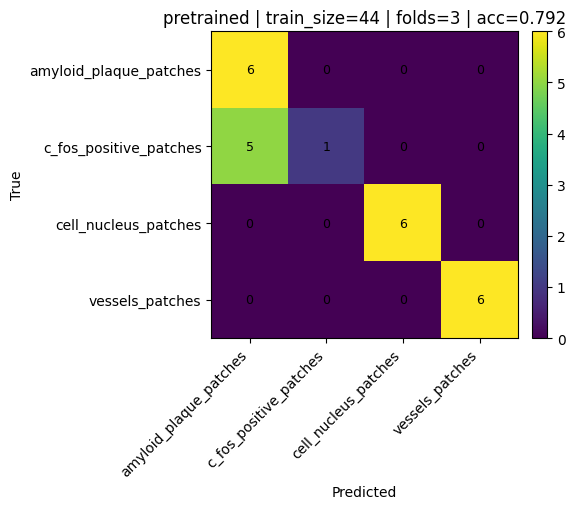

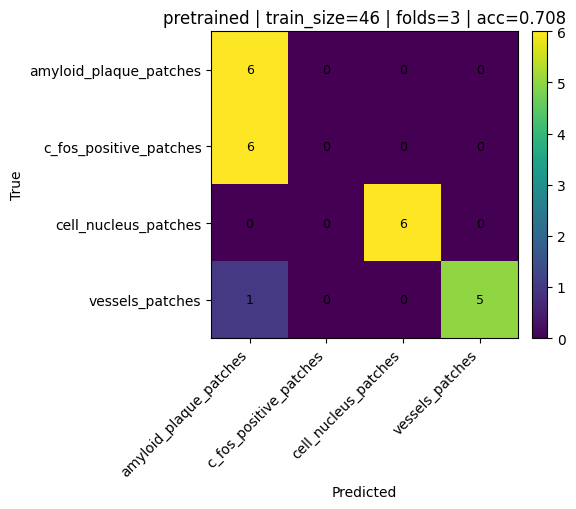

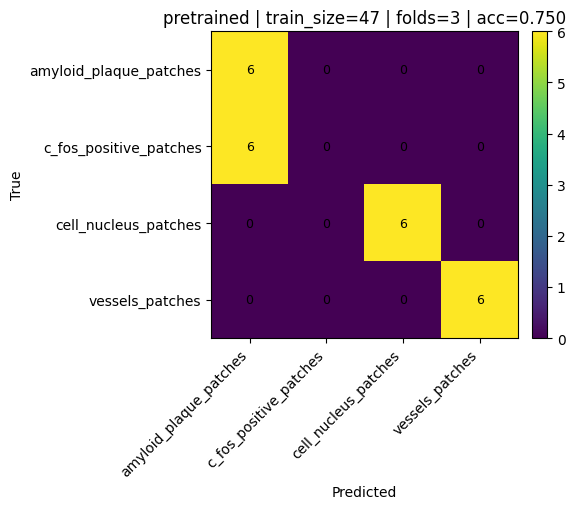

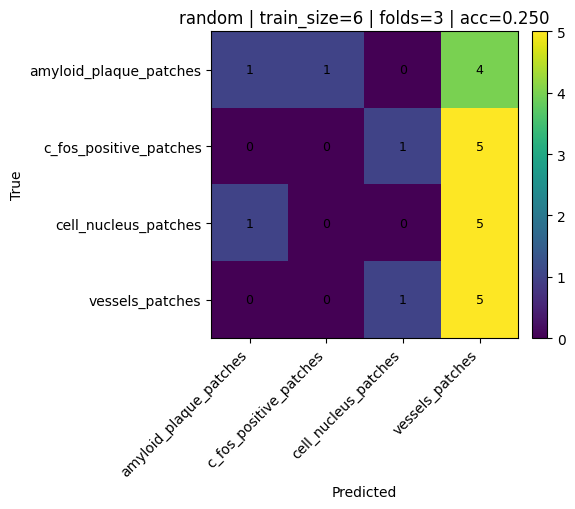

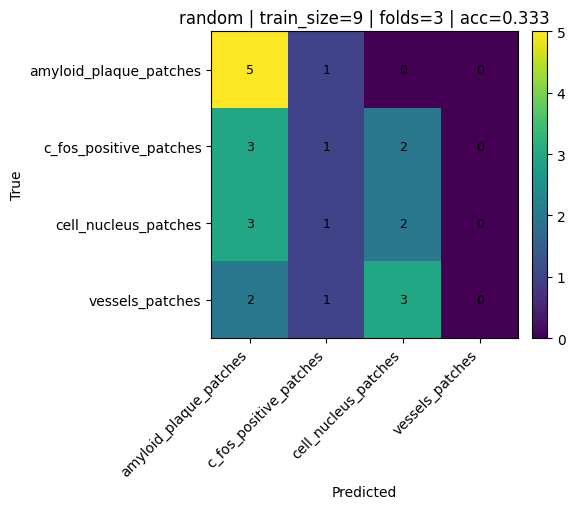

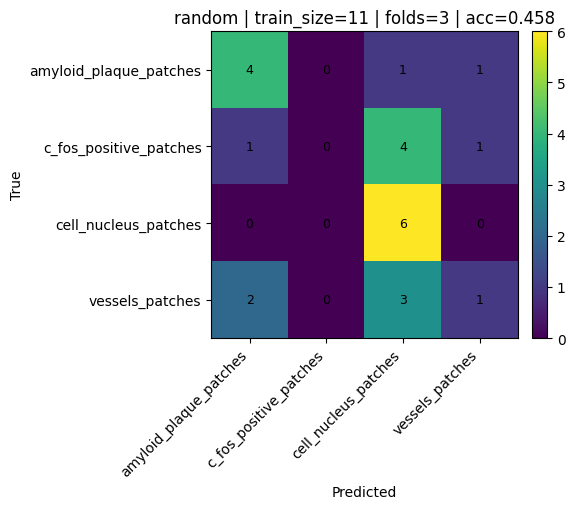

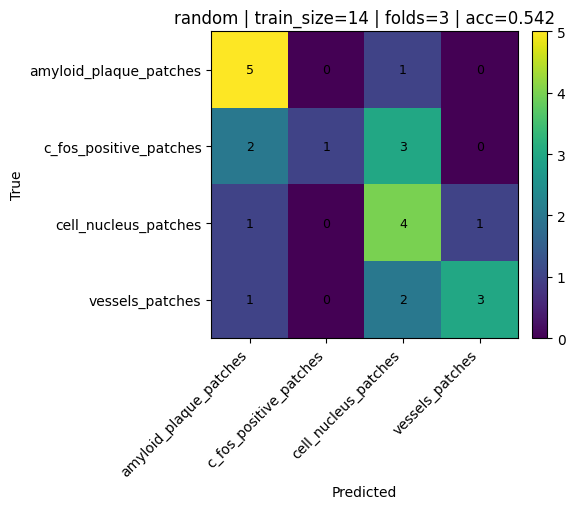

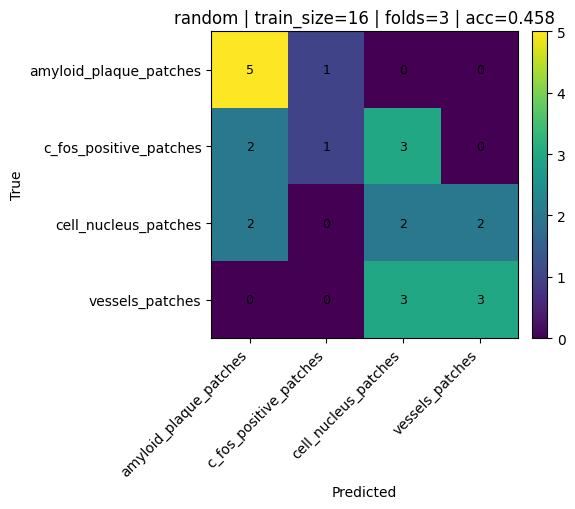

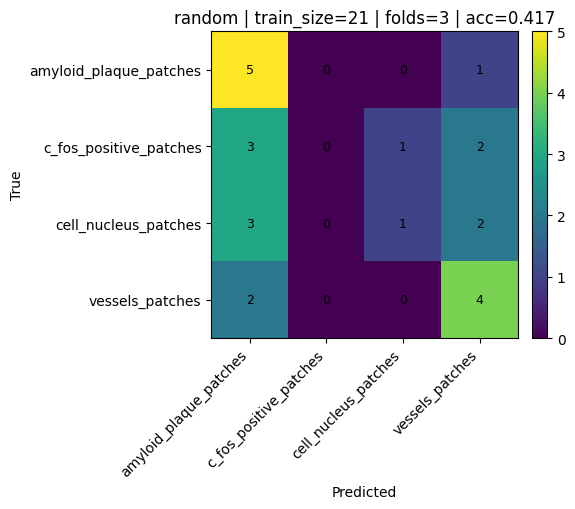

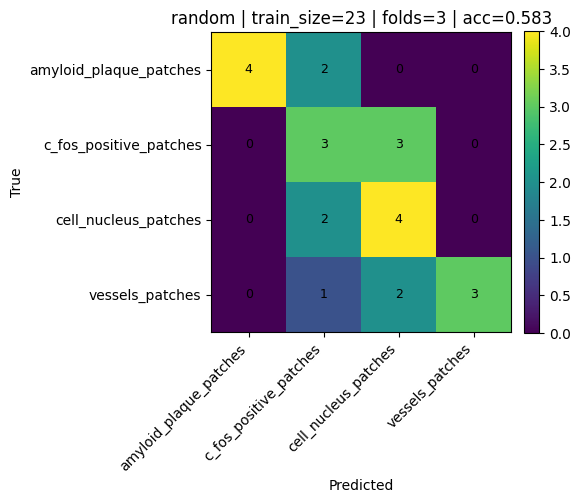

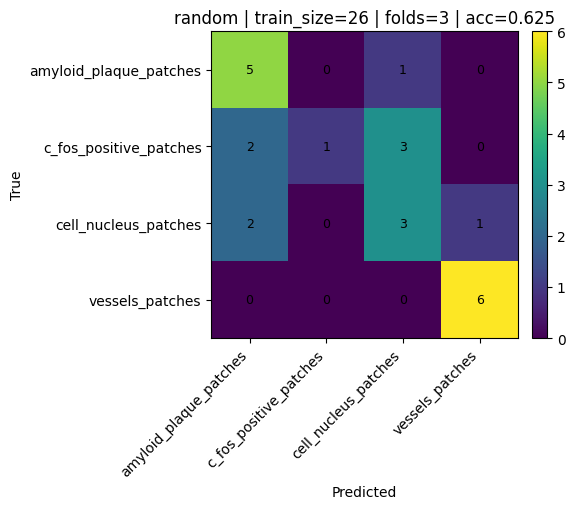

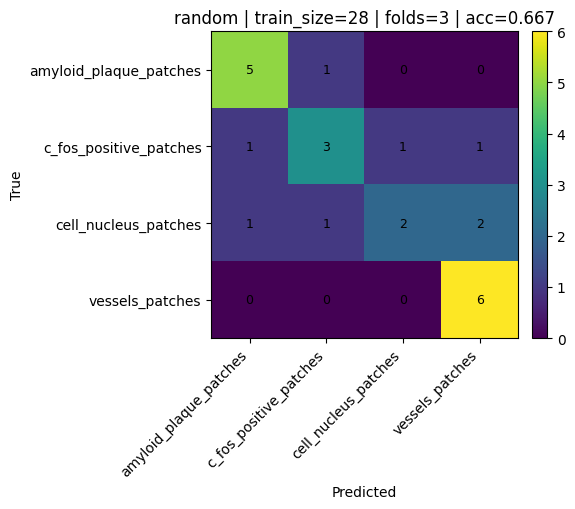

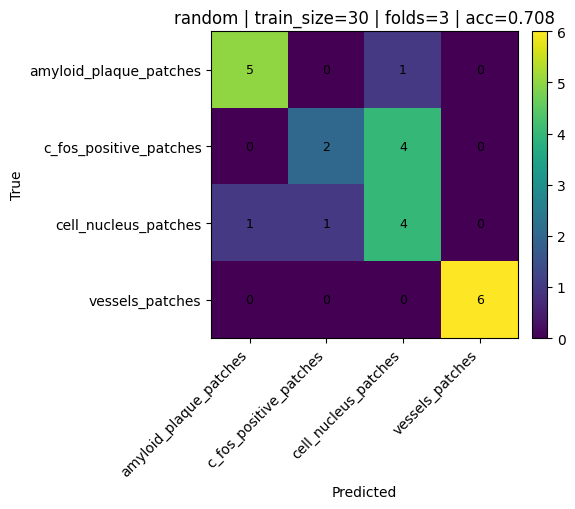

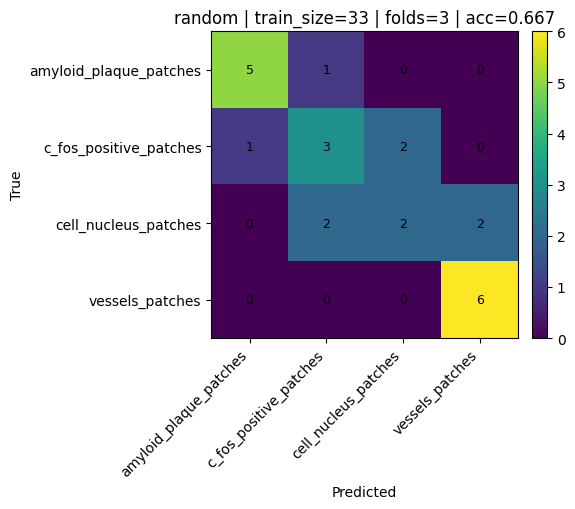

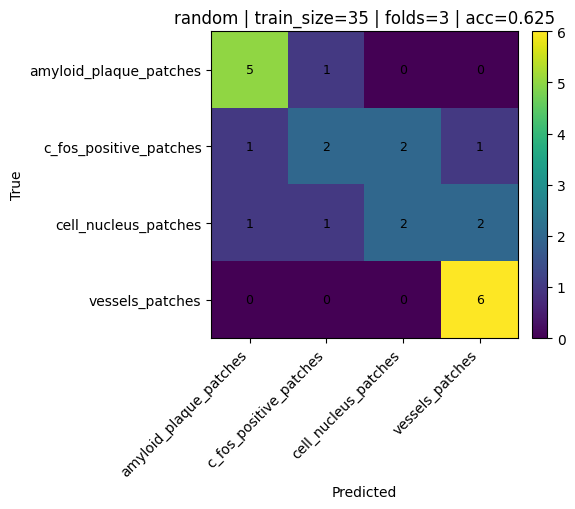

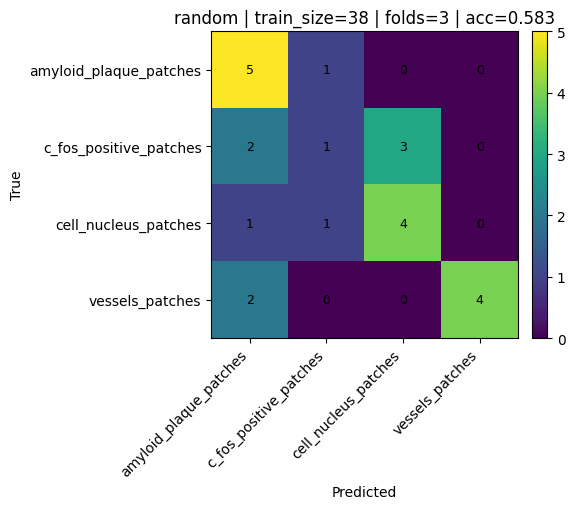

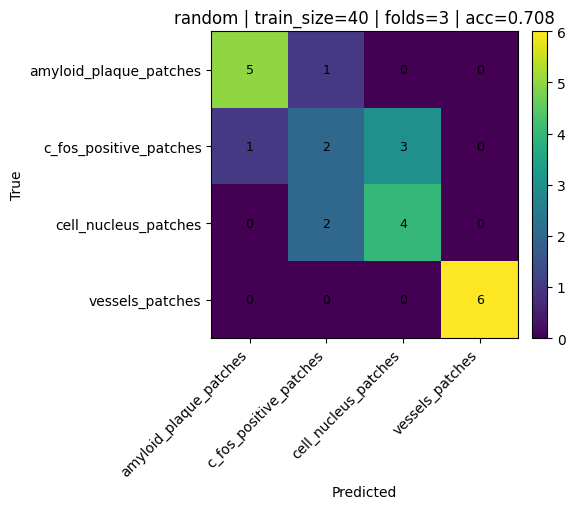

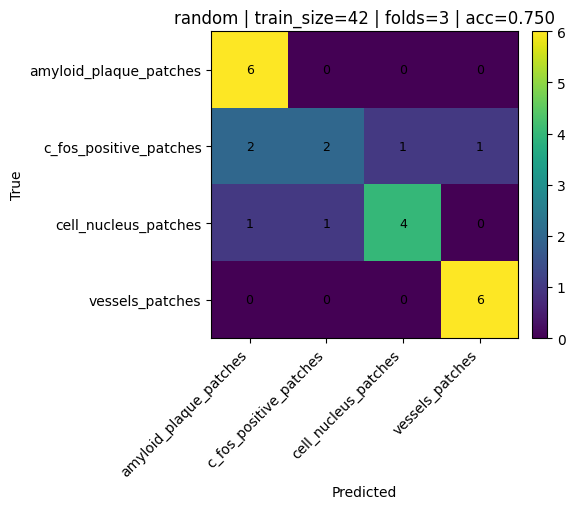

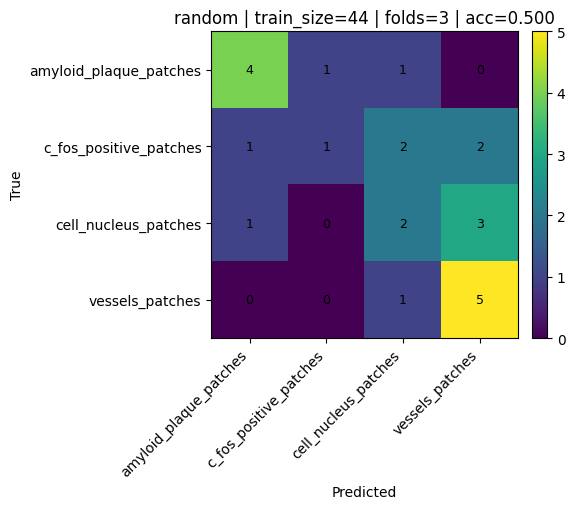

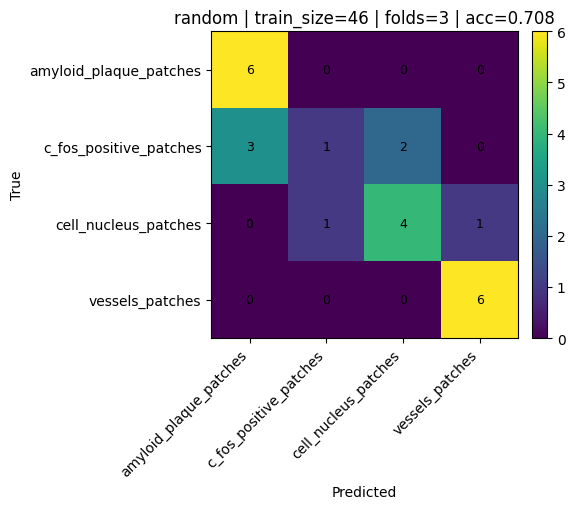

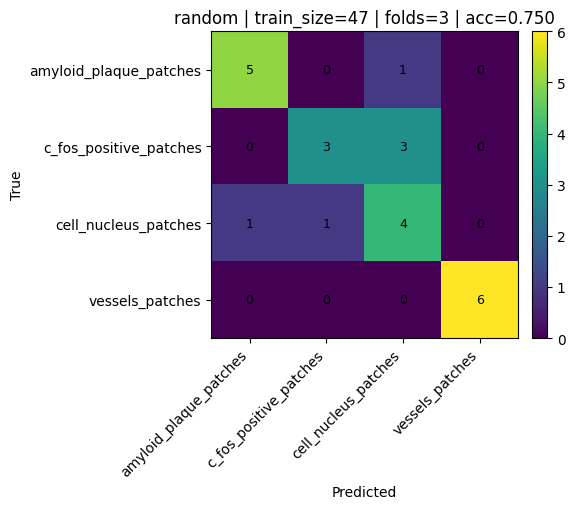

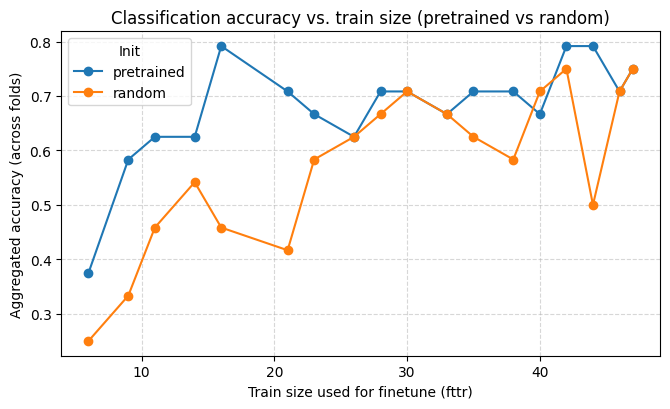

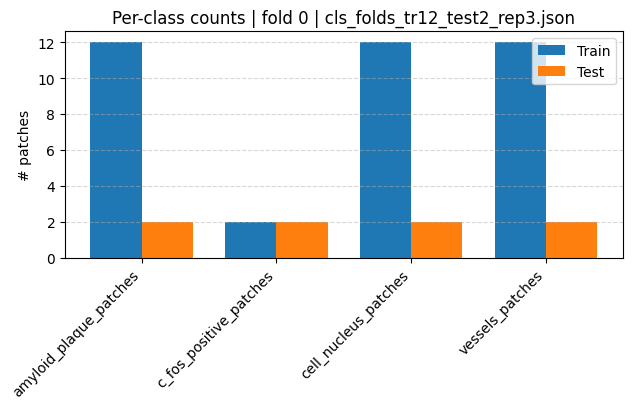

In [1]:
# ==== Classification CV plotting helper ====
# Scans classification metrics, aggregates/plots confusion matrices,
# and shows per-class Train/Test counts from your folds JSON.

import os, re, json, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ CONFIG ------------------
METRICS_DIR = Path("/ministorage/adina/classification_eval/folds3_test2/cls_metrics/classification")
FOLDS_DIR   = Path("/ministorage/adina/classification_eval/folds3_test2")
PLOT_INDIVIDUAL = False  # set True to also draw per-fold confusion matrices
# -------------------------------------------

def load_cm_csv(path: Path):
    """Load a confusion_matrix_*.csv saved by your script.
    Format assumed:
        header: ['', class1, class2, ...]
        rows:   [class_name_i, c11, c12, ...]
    Returns (classes: List[str], cm: np.ndarray[int])
    """
    df = pd.read_csv(path)
    # first col is class label row headers; first row has empty label
    classes = list(df.columns[1:])
    # rows each start with class name; ensure order matches column classes
    row_labels = df.iloc[:, 0].tolist()
    # reorder rows to column order if needed
    row_index = [row_labels.index(c) for c in classes]
    cm_vals = df.iloc[row_index, 1:].to_numpy(dtype=int)
    return classes, cm_vals

def parse_tag_from_filename(fname: str):
    """Extract cvfold and fttr (train size used for finetune) from tag string in filename."""
    # filenames look like: confusion_matrix_cvfold2_ntrXX_ntestYY_fttrAA_ftvalBB_seed100.csv
    m_fold = re.search(r'cvfold(\d+)', fname)
    m_fttr = re.search(r'_fttr(\d+)_', fname)
    fold_id = int(m_fold.group(1)) if m_fold else None
    fttr = int(m_fttr.group(1)) if m_fttr else None  # finetune train size
    return fold_id, fttr

def detect_mode_from_dir(dirname: str):
    """Infer mode (pretrained|random) from directory name."""
    name = dirname.lower()
    if "pretrained" in name:
        return "pretrained"
    if "random" in name:
        return "random"
    # fallback: try parent-of-parent
    return "unknown"

def scan_all_runs(metrics_dir: Path):
    """Walk metrics directory and collect all confusion_matrix csvs with metadata."""
    records = []
    for root, _, files in os.walk(metrics_dir):
        for f in files:
            if not f.startswith("confusion_matrix_") or not f.endswith(".csv"):
                continue
            fpath = Path(root) / f
            mode = detect_mode_from_dir(Path(root).name)
            fold_id, fttr = parse_tag_from_filename(f)
            classes, cm = load_cm_csv(fpath)
            total = cm.sum()
            acc = np.trace(cm) / max(1, total)
            records.append({
                "mode": mode,
                "train_size": fttr,
                "fold_id": fold_id,
                "classes": tuple(classes),
                "cm": cm,
                "acc": acc,
                "file": str(fpath),
            })
    df = pd.DataFrame(records)
    # Sort for readability
    if not df.empty:
        df = df.sort_values(["mode", "train_size", "fold_id"]).reset_index(drop=True)
    return df

def plot_confusion_matrix(cm, classes, title=None, normalize=False):
    """Basic confusion matrix plot with counts (and optional row-normalized values)."""
    fig, ax = plt.subplots(figsize=(5.8, 5.2))
    display = cm.astype(float)
    if normalize and cm.sum(axis=1).all():
        row_sums = cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        display = cm / row_sums

    im = ax.imshow(display, aspect='equal')
    ax.set_xticks(range(len(classes)))
    ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    if title:
        ax.set_title(title)

    # annotate
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            txt = f"{cm[i, j]:d}" if not normalize else f"{display[i, j]:.2f}"
            ax.text(j, i, txt, ha='center', va='center', fontsize=9)

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    return fig, ax

def aggregate_and_plot(df, plot_individual=False, normalize=False):
    """Aggregate CMs across folds per (mode, train_size) and plot."""
    if df.empty:
        print("No confusion matrices found at:", METRICS_DIR)
        return

    # Pretty index
    display_df = df[["mode", "train_size", "fold_id", "acc", "file"]].copy()
    from IPython.display import display
    print("Found runs:")
    display(display_df)

    # sanity: class sets should match per aggregate group
    groups = df.groupby(["mode", "train_size"], dropna=False)
    for (mode, tr), sub in groups:
        # check class consistency
        class_sets = set(sub["classes"])
        if len(class_sets) != 1:
            print(f"[WARN] Inconsistent class sets for {(mode, tr)}; using first.")
        classes = list(list(class_sets)[0])  # pick one
        agg_cm = None
        for _, row in sub.iterrows():
            agg_cm = row["cm"] if agg_cm is None else (agg_cm + row["cm"])

        acc = np.trace(agg_cm) / max(1, agg_cm.sum())
        title = f"{mode} | train_size={tr} | folds={len(sub)} | acc={acc:.3f}"
        plot_confusion_matrix(agg_cm, classes, title=title, normalize=normalize)
        plt.show()

        if plot_individual:
            for _, row in sub.iterrows():
                cm_i = row["cm"]
                acc_i = np.trace(cm_i) / max(1, cm_i.sum())
                t = f"{mode} | train_size={tr} | fold={row['fold_id']} | acc={acc_i:.3f}"
                plot_confusion_matrix(cm_i, classes, title=t, normalize=normalize)
                plt.show()

def plot_accuracy_vs_train_size(df):
    """Scatter/line plot of aggregated accuracy vs train_size for pretrained vs random."""
    if df.empty:
        print("No data to plot.")
        return

    rows = []
    for (mode, tr), sub in df.groupby(["mode", "train_size"], dropna=False):
        # sum cm across folds and compute acc
        agg = None
        classes = None
        for _, r in sub.iterrows():
            agg = r["cm"] if agg is None else (agg + r["cm"])
            classes = r["classes"]
        acc = np.trace(agg) / max(1, agg.sum())
        rows.append({"mode": mode, "train_size": tr, "acc": acc})
    agg_df = pd.DataFrame(rows).sort_values(["mode", "train_size"])

    fig, ax = plt.subplots(figsize=(6.8,4.2))
    for mode, sub in agg_df.groupby("mode"):
        ax.plot(sub["train_size"], sub["acc"], marker="o", label=mode)
    ax.set_xlabel("Train size used for finetune (fttr)")
    ax.set_ylabel("Aggregated accuracy (across folds)")
    ax.set_title("Classification accuracy vs. train size (pretrained vs random)")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(title="Init")
    plt.tight_layout()
    plt.show()

def plot_per_class_counts_from_json(json_path: Path, fold_id: int = 0):
    """Bar chart of per-class Train vs Test counts for a selected folds JSON and fold id."""
    meta = json.loads(Path(json_path).read_text())
    classes = meta.get("classes", [])
    folds = meta.get("folds", [])
    if not folds:
        print("No folds in:", json_path)
        return
    if fold_id < 0 or fold_id >= len(folds):
        print(f"fold_id {fold_id} out of range [0, {len(folds)-1}] for", json_path)
        return
    fold = folds[fold_id]
    train_paths = fold["train"]
    test_paths  = fold["test"]

    # count by class: detect class name by parent dir of the file path
    def tally(paths):
        counts = {c: 0 for c in classes}
        for p in paths:
            cname = Path(p).parent.name
            if cname in counts:
                counts[cname] += 1
        return counts

    train_counts = tally(train_paths)
    test_counts  = tally(test_paths)

    x = np.arange(len(classes))
    w = 0.38

    fig, ax = plt.subplots(figsize=(max(6.5, len(classes)*0.9), 4.2))
    ax.bar(x - w/2, [train_counts[c] for c in classes], width=w, label="Train")
    ax.bar(x + w/2, [test_counts[c] for c in classes],  width=w, label="Test")
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_ylabel("# patches")
    ax.set_title(f"Per-class counts | fold {fold_id} | {Path(json_path).name}")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# ------------------ RUN ------------------
df = scan_all_runs(METRICS_DIR)

# 1) Show aggregated confusion matrices (pretrained vs random) per train_size
aggregate_and_plot(df, plot_individual=PLOT_INDIVIDUAL, normalize=False)

# 2) Optional: overall accuracy vs train size
plot_accuracy_vs_train_size(df)

# 3) Example: per-class Train/Test counts for a particular train size JSON and fold
#    Pick one JSON that matches a train size you care about, e.g. TR=12 below:
example_json = FOLDS_DIR / "cls_folds_tr12_test2_rep3.json"  # <- change TR or REPEATS as needed
if example_json.exists():
    plot_per_class_counts_from_json(example_json, fold_id=0)  # change fold_id=0..rep-1
else:
    print(f"[Info] Example folds JSON not found: {example_json}")
